# Análise Descritiva dos Dados 

## Base: Crime Data in Brazil

### fonte: https://www.kaggle.com/inquisitivecrow/crime-data-in-brazil

### Para começar a 'add' estou importando as bibliotecas Pandas para fazer operações de sql e Seaborn par plotar gráficos.

In [1]:
import pandas as pd
import seaborn as sns

%matplotlib inline
%config IPCompleter.greedy=True

### Instalando e em seguida importando o psycopg2 que usarei para criar a conexão com o banco de dados

In [2]:
!pip install psycopg2

In [3]:
import psycopg2

In [5]:
conn = psycopg2.connect(host='localhost',database = 'Criminalidade',user='postgres',password='serra')

### Primeira análise rápida usando pg_stats

#### Foram escolhidos os campos que representam o nome do atributo, fração de nulos existentes em cada atributo, número de valores distintos, valores mais comuns e frequencia dos valores mais comuns

In [ ]:
resultado = pd.read_sql_query("""select attname,null_frac,n_distinct,most_common_vals,most_common_freqs from pg_stats where schemaname = 'public' """,conn)

In [ ]:
resultado

####  Ao olhar o campo null_frac, aparentemente vemos uma base sem nenhum valor null, exceto no atributo logradouro onde tem baixíssimo indice de nulos(0.0033% da base), porém olhando com uma maior atenção encontraremos alguns problemas, se observar o atributo datahora_ocorrencia_bo nos campos most_common_vals e most_common_freq, verá que o valor mais comum não é null e sim uma String 'NULL' e além disso a frequencia é 1, ou seja, esse atributo é completamente inválido e deverá ser removido do banco, pois não agrega nenhum valor ás nossas análises.


### Dropando a coluna datahora_ocorrencia_bo

In [ ]:
cur = conn.cursor()

In [ ]:
cur.execute("""alter table crime drop column datahora_comunicacao_bo """)

In [ ]:
pd.read_sql_query("""select attname,null_frac,n_distinct,most_common_vals,most_common_freqs from pg_stats where schemaname = 'public' """,conn)

#### Em um segundo olhar, logo vemos que mais atributos tem a String 'NULL' como uns dos valores mais comuns, então agora investigaremos alguns desses atributos de forma um pouco mais minuciosa, começando pelo último atributo cor_cutis.

In [ ]:
resultado3 = pd.read_sql_query("""select cor_cutis,count(*) from crime group by cor_cutis order by count(*) desc""",conn)

In [ ]:
resultado3

#### Com esse teste rapidamente percebemos 3 coisas, primeira de aproximadamente 1.602.000 registros, 2 em cor_cutis são realmente nulos, segunda os campos verdadeiramente nulos estão com a String 'NULL' e somam cerca de 400 mil registros, terceira apareceram vários números, logo, não são cores da pele. Vamos tentar descobrir a causa disso, vamos seleconar os dados onde cor_cutis é igual aos números.

In [ ]:
resultado4 = pd.read_sql_query("""select * from crime where not (cor_cutis like '%Branca%') and not (cor_cutis like '%Parda%') and cor_cutis not like '%Amarela%' and cor_cutis not like '%Vermelha%' and cor_cutis not like '%Preta%'  and cor_cutis not like '%Outros%' and cor_cutis is not null and cor_cutis not like '%NULL%'

""",conn)

In [ ]:
resultado4

#### Perceba que a linha por algum motivo deu um SHIFT na hora do ETL e corrompeu esses dados, ou seja, a idade está em cor_cutis, como achamos esse resultado no último atributo, todas as linhas afetadas por esse shift estão presentes, logo apagaremos todas essas linhas da nossa base de dados, juntamente com as linhas onde 'cor_cutis' = "NULL" e onde os dados são verdadeiramente nulos.

In [ ]:
cur = conn.cursor()

In [ ]:
cur.execute("""delete from crime where not (cor_cutis like '%Branca%') and not (cor_cutis like '%Parda%') and cor_cutis not like '%Amarela%' and cor_cutis not like '%Vermelha%' and cor_cutis not like '%Preta%'  and cor_cutis not like '%Outros%'""")

In [ ]:
resultado5 = pd.read_sql_query("""select cor_cutis,count(*) from crime group by cor_cutis order by count(*) desc""",conn)

In [ ]:
resultado5

#### Agora vamos analisar outras colunas que requerem uma formatação especial, por exemplo, a coluna hora_ocorrencia_bo que registra a hora da ocorrencia de um bo e está em um formato txt. 

In [ ]:
resultado6 = pd.read_sql_query("""select hora_ocorrencia_bo,count(*) from crime group by hora_ocorrencia_bo order by count(*) desc""",conn)

In [ ]:
resultado6

#### Ao final do resultado6, observamos que aparecem alguns dados em formato impróprio para a manipulação no banco de dados, agora faremos uma verificação se são os unicos casos em que isso ocorre ou se existem outros casos com mais número de registros onde isso ocorre, ou seja, onde hora_ocorrencia_bo é diferente de String 'NULL' e diferente de formato 12:00.

In [ ]:
resultado7 = pd.read_sql_query("""select hora_ocorrencia_bo from crime where hora_ocorrencia_bo not like '%:%' and hora_ocorrencia_bo not like 'NULL'""",conn)

In [ ]:
resultado7

#### Como existem poucos dados que foram inseridos com uma formatação inadequada, faremos 3 alterações para mudar os valores desse atributo para o formato correto

In [29]:
cur = conn.cursor()

In [30]:
cur.execute("""update crime set hora_ocorrencia_bo = '15:50' where hora_ocorrencia_bo = '15H50' """)

In [31]:
cur.execute("""update crime set hora_ocorrencia_bo = '23:00' where hora_ocorrencia_bo = '23H00' """)

In [32]:
cur.execute("""update crime set hora_ocorrencia_bo = '19:10' where hora_ocorrencia_bo = '1910' """)

In [86]:
resultado8 = pd.read_sql_query("""select hora_ocorrencia_bo from crime where hora_ocorrencia_bo not like '%:%' and hora_ocorrencia_bo not like 'NULL'""",conn)

In [87]:
cur.execute("commit")

In [88]:
resultado8.head()

,hora_ocorrencia_bo


#### Agora vamos converter o horario para o formato certo

In [89]:
resultado9 = pd.read_sql_query("""select hora_ocorrencia_bo from crime where hora_ocorrencia_bo like '%:%' """,conn)

In [90]:
resultado9.head()

,hora_ocorrencia_bo
0,06:20
1,06:10
2,05:30
3,12:05
4,05:50


#### Formatando o horario

In [91]:
resultado8['hora_ocorrencia_bo'] = pd.to_datetime(resultado9['hora_ocorrencia_bo'])

In [92]:
resultado8.head()

,hora_ocorrencia_bo
0,2019-10-08 06:20:00
1,2019-10-08 06:10:00
2,2019-10-08 05:30:00
3,2019-10-08 12:05:00
4,2019-10-08 05:50:00


In [38]:
resultado8['hora_ocorrencia_bo'] = pd.to_datetime(resultado8['hora_ocorrencia_bo'], format= '%H:%M').dt.time

In [82]:
stamp = datetime(2011, 1, 3)
str(stamp)

'2011-01-03 00:00:00'
In [24]: stamp.strftime('%Y-%m-%d')


NameError: name 'stamp' is not defined

In [78]:
import numpy as np
bins = pd.timedelta_range(0, periods=24, freq='H')
bins64 = pd.to_datetime(bins)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
hour_count['hora_ocorrencia_bo'] = pd.to_datetime(hour_count['hora_ocorrencia_bo'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [77]:
hour_count.dtypes['hora_ocorrencia_bo']

dtype('<M8[ns]')

In [75]:
type(bins64)

pandas.core.indexes.datetimes.DatetimeIndex

In [42]:
hour_count = resultado10.head(100)

In [79]:
rec= pd.cut(hour_count['hora_ocorrencia_bo'],bins64)

In [80]:
rec

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
     ... 
70    NaN
71    NaN
72    NaN
73    NaN
74    NaN
75    NaN
76    NaN
77    NaN
78    NaN
79    NaN
80    NaN
81    NaN
82    NaN
83    NaN
84    NaN
85    NaN
86    NaN
87    NaN
88    NaN
89    NaN
90    NaN
91    NaN
92    NaN
93    NaN
94    NaN
95    NaN
96    NaN
97    NaN
98    NaN
99    NaN
Name: hora_ocorrencia_bo, Length: 100, dtype: category
Categories (23, interval[datetime64[ns]]): [(1970-01-01, 1970-01-01 01:00:00] < (1970-01-01 01:00:00, 1970-01-01 02:00:00] < (1970-01-01 02:00:00, 1970-01-01 03:00:00] < (1970-01-01 03:00:00, 1970-01-01 04:00:00] ... (1970-01-01 19:00:00, 1970-01-01 20:00:00] < (1970-01-01 20:00:00, 1970-01-01 21:00:00] < (1970-01-01 21:00:00, 1970-0

### Aproveitando a onda dos horarios, vamos fazer um estudo de qual horario aparece mais.

In [40]:
resultado10 = pd.read_sql_query("""select hora_ocorrencia_bo, count(*) from crime group by hora_ocorrencia_bo order by count(*) """,conn)


In [22]:
resultado10[:-2]

,hora_ocorrencia_bo,count
0,1910,1
1,23H00,2
2,15H50,2
3,05:09,16
4,04:41,18
5,04:21,18
6,04:02,20
7,04:22,21
8,03:54,22
9,05:14,22


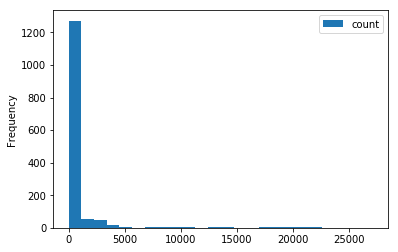

In [21]:
graph.plot(kind='hist',bins=24)